# Testing Reliability of Prompting
- Comparing logits with LLM answer
- Given a specific answer how big is the corresponding token probability?


In [ ]:
# packages and helpers
import random
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import pandas as pd
import gc
import matplotlib.pyplot as plt
import numpy as np


def randomized_choice_numbers():
    possible_pairs = [[1,8], [2, 9], [8, 1], [9, 2]]
    var_1, var_2 = random.choice(possible_pairs)
    return var_1, var_2

def randomized_prompt():
    var1, var2 = randomized_choice_numbers()
    remember_vars = [var1, var2]
    
    prompt = f"""
    How do you see yourself: are you generally fully prepared to take risks or do you try to avoid taking risks? 
    Please reply with a number between {var1} and {var2}. 
    The value {var1} means: ‘not at all willing to take risks’ and the value {var2} means: ‘very willing to take risks’. 
    Please answer with the number between {var1} and {var2} that describes you best. Answer: """

    return prompt, remember_vars

def normalize_scale(row):
    start, end = row["prompt_numbers"]
    tokens = row["Token"].copy()
    probs  = row["Probability"].copy()

    if [start, end] == [1, 8]:
        # nothing to change, except deleting value for 9
        tokens.pop()
        probs.pop()
        return tokens, probs
    
    elif [start, end] == [8, 1]:
        tokens.pop()
        probs.pop()
        probs.reverse()
        return tokens, probs

    elif [start, end] == [2, 9]:
        tokens.pop()
        # shift down by 1
        probs.pop(0)        
        return tokens, probs

    elif [start, end] == [9, 2]:
        # reverse order + shift
        tokens.pop()
        probs.pop(0)
        probs.reverse()
        return tokens, probs

    else:
        raise ValueError(f"Unexpected scale {start} → {end}")


In [2]:
# Load model and tokenizer
model_names = ["HuggingFaceTB/SmolLM2-1.7B-Instruct",  "unsloth/Qwen3-1.7B", "unsloth/Qwen3-4B"] # "bigscience/bloomz-3b", "tiiuae/falcon-7b-instruct"]
short_model_names = ["SmolLM2-1.7B-I", "Qwen3-1.7B-I","Qwen3-4B-I" ,"bloomz-3b1", "bloomz-3b", "falcon-7b-i"]


In [3]:
save_data_in_table_list = []
j=0
for model_name in model_names:
	short_model_name = short_model_names[j]
	j+=1
	tokenizer = AutoTokenizer.from_pretrained(model_name)
	model = AutoModelForCausalLM.from_pretrained(model_name)

	for i in range(16):
		# generate prompt with random number combi
		prompt, remember_vars  = randomized_prompt()

		# Model specific chat template for prompting
		messages = [
			{"role": "user", "content": prompt},
		]

		# input settings
		inputs = tokenizer.apply_chat_template(
			messages,
			add_generation_prompt=True,
			tokenize=True,
			return_dict=True,
			return_tensors="pt",
			skip_special_tokens=True,
			enable_thinking=False
		).to(model.device)

		# generate output text and print
		generated_outputs = model.generate(**inputs, max_new_tokens=40)
		generated_text = tokenizer.decode(
			generated_outputs[0][inputs["input_ids"].shape[-1]:],
				skip_special_tokens=True)

		#print("Generated text:", generated_text)

		# generate output logits (from inner last layer of model)
		with torch.no_grad():
			logit_outputs = model(**inputs)
			logits = logit_outputs.logits

		# Take the logits for the *last* position in the prompt
		next_token_logits = logits[0, -1, :]

		# Convert to probabilities
		probs = torch.softmax(next_token_logits, dim=-1)

		# Extract most likely token (= max logit value) and its prob (i.e. softmax function = exp of logits and divided by sum of all expnential logits so that probs sum up to)
		predicted_id = torch.argmax(probs).item()
		predicted_token = tokenizer.decode(predicted_id)
		predicted_prob = probs[predicted_id].item()

		# Extract the *actual generated* token and its prob at first response position!
		# Take only the first token
		generated_tokens = generated_outputs[0][inputs["input_ids"].shape[-1]:]
		first_generated_id = generated_tokens[0].item()
		actual_token = tokenizer.decode([first_generated_id], skip_special_tokens=True)
		actual_prob = probs[first_generated_id].item()

		# Add probabilities for 1-9
		# Get token IDs for numbers 1–9
		token_ids = [tokenizer.encode(str(i), add_special_tokens=False)[0] for i in range(1, 10)]
		# Extract their probabilities
		selected_probs = probs[token_ids]
		# Decode tokens for display
		tokens = [tokenizer.decode([tid]) for tid in token_ids]
		probs_list = selected_probs.tolist()

		save_data_in_table_list.append(
			{
				"model": short_model_name,
				"prompt_numbers": remember_vars,
				"predicted_token": predicted_token,
				"predicted_prob": predicted_prob,
				"actual_token": actual_token,
				"actual_prob": actual_prob,
				"Token": tokens,
				"Probability": probs_list
			}
		)
	# After finishing work with the model
	print(f"Model {short_model_name} done!")
	del model
	del tokenizer

	# Run garbage collector
	gc.collect()

df = pd.DataFrame(save_data_in_table_list)


Model SmolLM2-1.7B-I done!
Model Qwen3-1.7B-I done!


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model Qwen3-4B-I done!


In [4]:
#df.to_csv("tryPromptingData.csv", index=False)

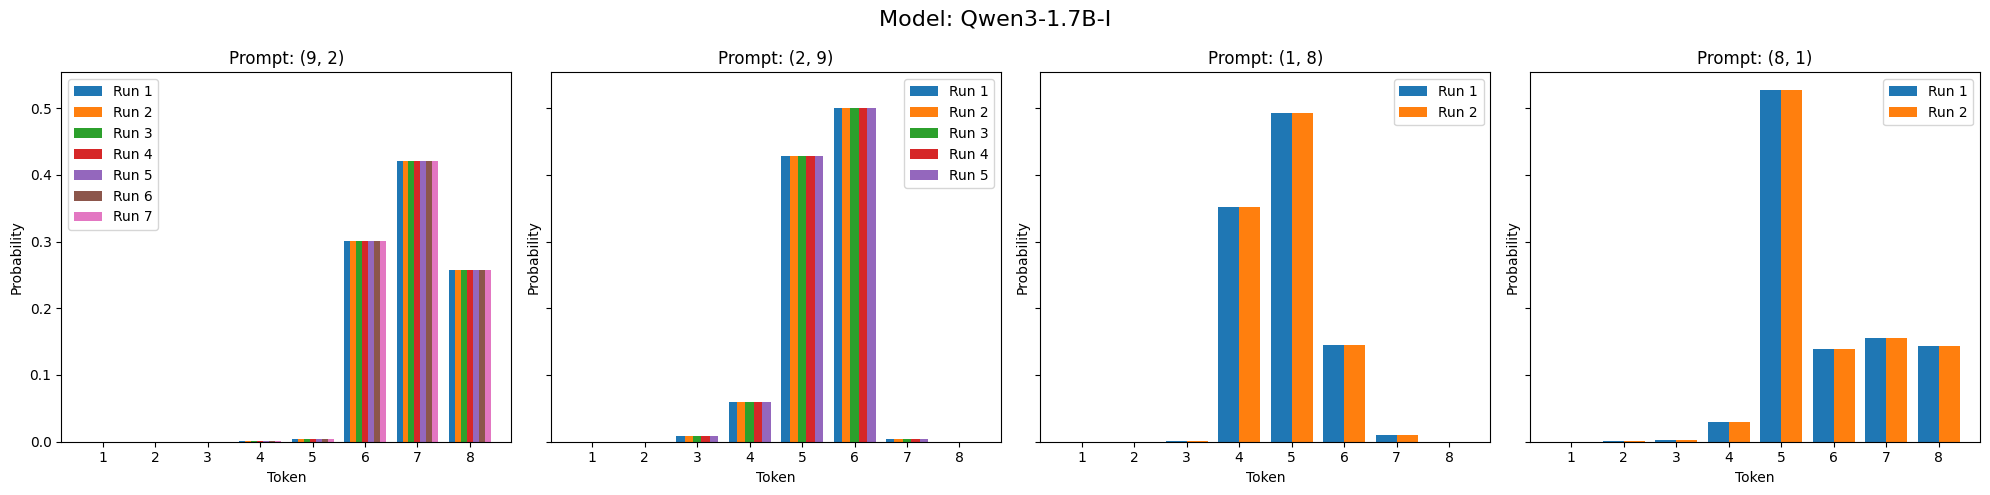

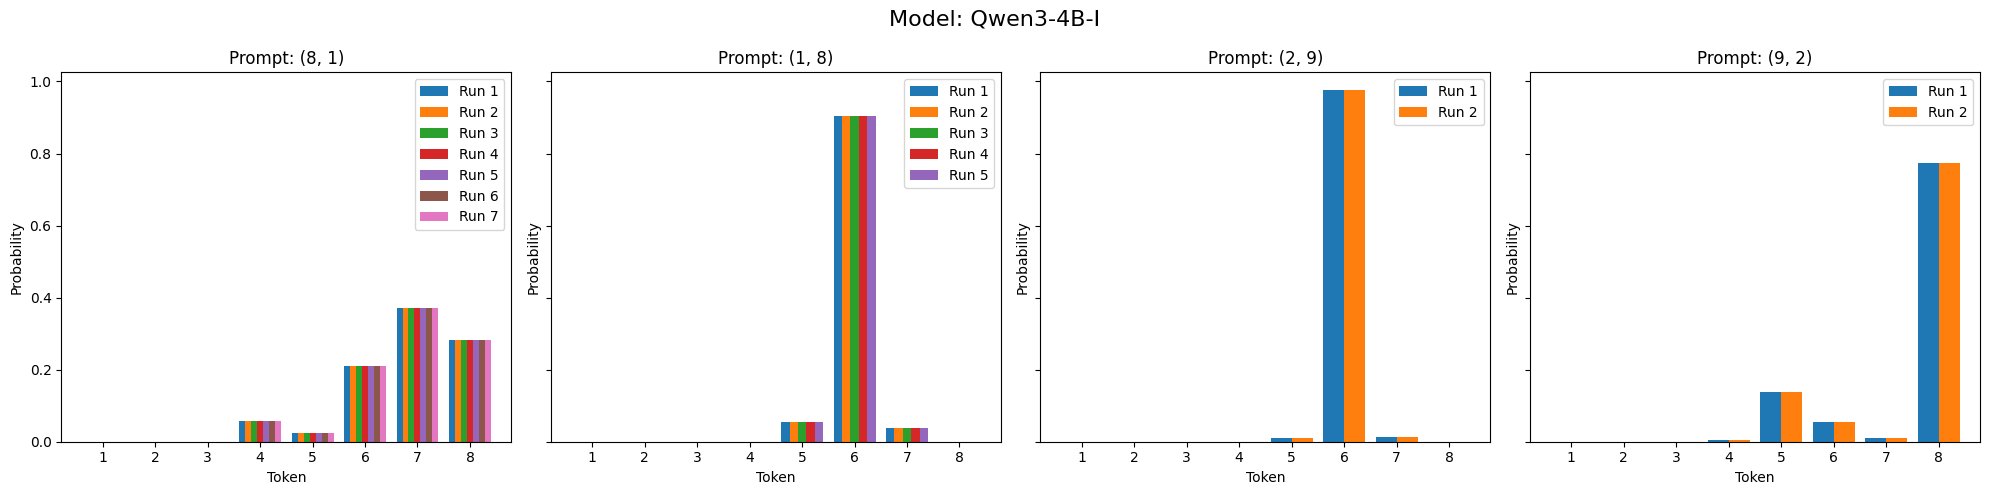

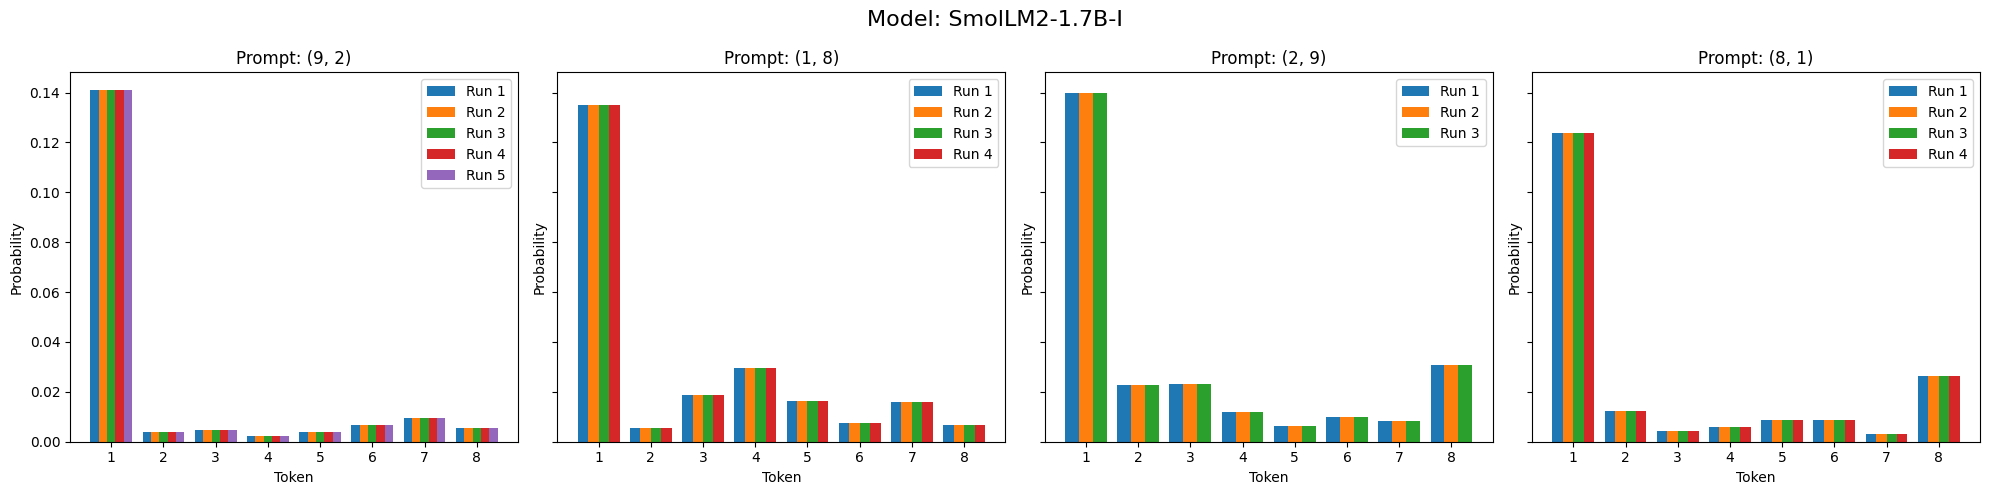

In [5]:
# zurück auf einen Nenner bringen, für verbesserte Vergleichbarkeit. 

# Apply function to normalize scales to dataframe
df[["Token_normalized", "Prob_normalized"]] = df.apply(
    lambda row: pd.Series(normalize_scale(row)), axis=1
)

df["prompt_tuple"] = df["prompt_numbers"].apply(lambda x: tuple(x))

# Loop over each model
for model, model_df in df.groupby("model"):

    # Get unique prompt_numbers within this model
    prompts = model_df["prompt_tuple"].unique()
    n_prompts = len(prompts)

    # Create one column per prompt_numbers
    fig, axes = plt.subplots(1, n_prompts, figsize=(5*n_prompts, 5), sharey=True)

    # If only 1 prompt, axes is not a list
    if n_prompts == 1:
        axes = [axes]

    for ax, prompt in zip(axes, prompts):
        subset = model_df[model_df["prompt_tuple"] == prompt]

        # Assume all rows have the same tokens order
        tokens = subset.iloc[0]["Token_normalized"]
        x = np.arange(len(tokens))
        width = 0.8 / len(subset)   # distribute bars within each token group

        # Plot each run (row) as a differently colored bar
        for i, (_, row) in enumerate(subset.iterrows()):
            probs = row["Prob_normalized"]
            ax.bar(x + i*width, probs, width, label=f"Run {i+1}")

        ax.set_title(f"Prompt: {prompt}")
        ax.set_xticks(x + width*(len(subset)-1)/2)
        ax.set_xticklabels(tokens)
        ax.set_xlabel("Token")
        ax.set_ylabel("Probability")
        ax.legend()

    fig.suptitle(f"Model: {model}", fontsize=16)
    plt.tight_layout()
    plt.show()
